<a href="https://colab.research.google.com/github/AYA-NASH/NN_with_TensorFlow/blob/main/6_FoodVision_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importing helper functions and downloading the 101Food data set:

In [ ]:
# getting the helpr_funcions.py file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-08 06:08:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-08 06:08:12 (96.9 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
# imorting the functions that we will use:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

**Download data and create train and test batches:**

In [ ]:
# downloading the 101_food_classes_10_percent zip file
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

--2023-01-08 06:08:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  23.7MB/s    in 68s     

2023-01-08 06:09:22 (22.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
unzip_data("101_food_classes_10_percent.zip")

In [ ]:
import tensorflow as tf
train_path = "101_food_classes_10_percent/train/"
test_path = "101_food_classes_10_percent/test/"
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_path,
                                                                                image_size = IMG_SIZE,
                                                                                label_mode = 'categorical')

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_path,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


###Building The model
Steps:
 1. create modelcheckpoint callback
 2. data augmentation layer
 3. base_model (feature extraction of the EfficientNetB0)
 4. validate on 15% of test_data for 5 epochs
 5. Fine tune the model (last 5 layers for further 5 epochs)

**1. ModelCheckpoint callback**

In [ ]:
# define the path where the checkpoint will saved at:
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor = 'val_accuracy',
                                                         verbose = 1,
                                                         save_best_only = True,
                                                         save_weights_only = True)

**2. Data Augmentation layer**

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name = 'data_augmentation_layer')

**3. Building the base_model (feature-extraction)**

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
# freeze pre-trained patterns
base_model.trainable = False

# creating inputs
input_shape = (224,224,3)
inputs = tf.keras.layers.Input(input_shape, name = 'Input_shape')
x = data_augmentation(inputs)

# passing augmented data through the base_model
x = base_model(x, training = False)
# Average pooling (to condense the outputs of the base model into a shape usable by the output layer)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
# create the output layer
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names),
                                activation = 'softmax',
                                name = 'output_layer')(x)

# Combine inputs with Outputs:
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_shape (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

**4. Compiling and Evaluating the model**

In [ ]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit:
initial_epochs = 5
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.3754 - accuracy: 0.2749
Epoch 1: val_accuracy improved from -inf to 0.43061, saving model to 101_classes_10_percent_data_model_checkpoint
237/237 [==============================] - 95s 343ms/step - loss: 3.3754 - accuracy: 0.2749 - val_loss: 2.5310 - val_accuracy: 0.4306
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.2106 - accuracy: 0.4937
Epoch 2: val_accuracy improved from 0.43061 to 0.48543, saving model to 101_classes_10_percent_data_model_checkpoint
237/237 [==============================] - 77s 323ms/step - loss: 2.2106 - accuracy: 0.4937 - val_loss: 2.1123 - val_accuracy: 0.4854
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.8245 - accuracy: 0.5690
Epoch 3: val_accuracy improved from 0.48543 to 0.52172, saving model to 101_classes_10_percent_data_model_checkpoint
237/237 [==============================] - 72s 303ms/step - loss: 1.8245 - accuracy: 0.5690 - val_l

In [ ]:
# Evaluating the model:
results_feature_extraction_model = model.evaluate(test_data)

results_feature_extraction_model

790/790 [==============================] - 71s 90ms/step - loss: 1.5772 - accuracy: 0.5858


[1.57718026638031, 0.585821807384491]

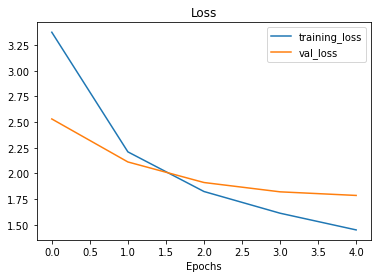

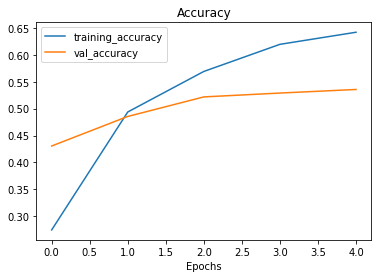

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

**5. Fine Tuning**

In [ ]:
# make the last 5 layers of the base model trainable

# for layer_number , layer in reversed(list(enumerate(base_model.layers))):
#   if layer_number == (len(base_model.layers) - 7):
#     break
#   layer.trainable = True

base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

Input_shape True
data_augmentation_layer True
efficientnetb0 True
global_average_pooling True
output_layer True


In [ ]:
# fitting the model
fine_tune_epochs = initial_epochs + 5
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 52s 215ms/step - loss: 1.3300 - accuracy: 0.6721 - val_loss: 1.7790 - val_accuracy: 0.5334
Epoch 6/10
237/237 [==============================] - 51s 213ms/step - loss: 1.2409 - accuracy: 0.6936 - val_loss: 1.7501 - val_accuracy: 0.5381
Epoch 7/10
237/237 [==============================] - 50s 210ms/step - loss: 1.1507 - accuracy: 0.7167 - val_loss: 1.7388 - val_accuracy: 0.5387
Epoch 8/10
237/237 [==============================] - 47s 198ms/step - loss: 1.0814 - accuracy: 0.7314 - val_loss: 1.6955 - val_accuracy: 0.5458
Epoch 9/10
237/237 [==============================] - 45s 189ms/step - loss: 1.0229 - accuracy: 0.7444 - val_loss: 1.7198 - val_accuracy: 0.5442
Epoch 10/10
237/237 [==============================] - 44s 183ms/step - loss: 0.9553 - accuracy: 0.7640 - val_loss: 1.6955 - val_accuracy: 0.5535


In [ ]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 61s 78ms/step - loss: 1.4983 - accuracy: 0.5984


[1.4983153343200684, 0.5984158515930176]

In [ ]:
# Save model to drive so it can be used later 
model.save("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model")


##Evaluating the Performance of the model:

In [ ]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

--2023-01-08 06:26:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.2’

06_101_food_class_1 100%[===================>]  44.59M  15.3MB/s    in 2.9s    

2023-01-08 06:26:14 (15.3 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.2’ saved [46760742/46760742]



In [ ]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 62s 76ms/step - loss: 1.8027 - accuracy: 0.6078


(1.8027206659317017, 0.6077623963356018)

In [ ]:
# Make predictons:
pred_probs = model.predict(test_data)

790/790 [==============================] - 64s 79ms/step


In [ ]:
len(pred_probs)


25250

In [ ]:
# y_preds = []
# for tensor in preds_probs:
#   y_preds.append(tf.argmax(tensor).numpy())

# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# Unbatch the test set and pull out the true-labels:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [ ]:
# y-labels is in the same order as pred_classes
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

##Evaluating Predictions:

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

**evaluating every individual class**

In [ ]:
from sklearn.metrics import classification_report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict = True)

# classification_report_dict

In [ ]:
class_names = test_data.class_names
# class_names

In [ ]:
# Etracting the f1_score from the classification_report_dict
# trim the part that starts with the key of 'accuracy' from the dictionary
class_f1_scores = {}
for key, value in classification_report_dict.items():
  if key == "accuracy":
    break
  # key is the index of the corresponding class
  # and we want the key of the class_f1_scores dictionary to be the class name and its value is the f1 score
  # value is a dictionary of metrics, so we will access the f1_score metric
  class_f1_scores[class_names[int(key)]] = value['f1-score'] 

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# Visualizing the f1_scores as a data frame:
import pandas as pd
f1_scores = pd.DataFrame({"class_name":list(class_f1_scores.keys()),
                          "f1_score":list(class_f1_scores.values())}).sort_values("f1_score", ascending = False)

f1_scores

,class_name,f1_score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


**Visualizing scores as a horizontal bar graph**

Approach:

* Importing matplotlib.pyplot as plt
* Creating list y   for discrete values on y-axis
* Creating list x  consisting only numeric data for discrete values on x-axis
* Calling plt.barh() function with parameters y,x as plt.barh(y,x)
* Setting x_label() and y_label()
* Setting title() for our bar chart
* Calling plt.show() for visualizing our chart


In [ ]:
# import matplotlib.pyplot as plt
# y = list(class_f1_scores.keys())
# x = list(class_f1_scores.values())

# plt.barh(y,x)
# plt.set_yticklabels(list(f1_scores["class_name"]))
# plt.xlabel("f1_scores")
# plt.ylabel("Class name")

# plt.title("F1 score for different classes")
# plt.show()

##Visualizing predictions on test images:


In [ ]:
# define a function to preprocess a custom image to run the model on it
def load_and_prep_image(filename, img_shape=224, scale=True):
  # 1- read in the target image
  # filename: string of the image path
  target_img = tf.io.read_file(filename)
  # 2- decoding the img (convert i ino a tensor)
  img = tf.io.decode_image(target_img, channels = 3)
  # 3- resize the img:
  img = tf.image.resize(img, [img_shape, img_shape])
  # scale img of necessary
  if scale:
    img = img/255.
  return img

1/1 [==============================] - 0s 25ms/step


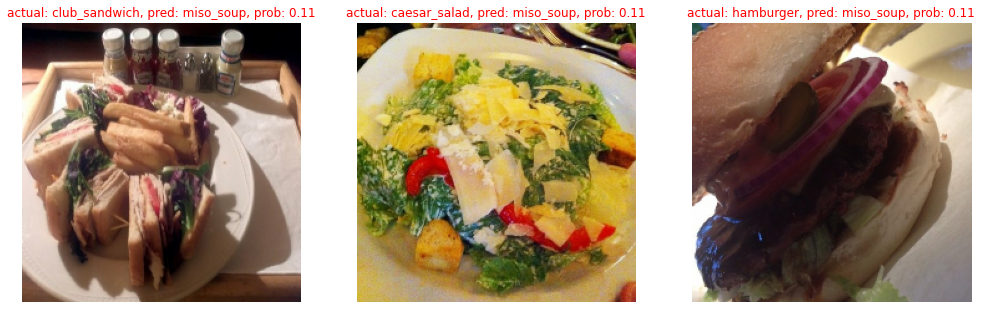

In [ ]:
# we need to visualize : image (input to the model), target label , and the prdicted label:
import os
import random
import matplotlib.pyplot as plt

plt.figure(figsize = (17,10))
for i in range(3):
  # get a random class:
  rand_class = random.choice(class_names)
  class_path = test_path + '/' + rand_class
  # pick a random image from the generated random class
  rand_img = random.choice(os.listdir(class_path)) #rand_img will be the name of the image file 
  # load the img and run prediction on it:
  filename = class_path + '/' + rand_img
  img = load_and_prep_image(filename)
  pred_prob = model.predict(tf.expand_dims(img, axis = 0))
  predicted_class = class_names[pred_prob.argmax()]

  # plot the images labled by the original and the prdicted labels:
  plt.subplot(1,3, i+1)
  plt.imshow(img)

  if rand_class == predicted_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {rand_class}, pred: {predicted_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

##Finding the most wrong predictions

collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

* Get all of the image file paths in the test dataset using the list_files() method.
* Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
* Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
* Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
* Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
file_paths = []
#  "/path/to/dir/*.py" 
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle = False):
  file_paths.append(filepath.numpy())

file_paths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
import pandas as pd
pred_df = pd.DataFrame({"img_path":file_paths,
                        "y_true":y_labels,
                        "y_pred":pred_classes,
                        "pred_conf":pred_probs.max(axis = 1),
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})

In [ ]:
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658606,apple_pie,pulled_pork_sandwich
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367901,apple_pie,prime_rib


In [ ]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]

pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza,False
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie,True
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658606,apple_pie,pulled_pork_sandwich,False
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367901,apple_pie,prime_rib,False


In [ ]:
# creating a subset of the pred_df that is sorted by the most wrong prediction:
# where the pred_correct is False and the pred_conf is very high
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending = False)

In [ ]:
top_100_wrong

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
21810,b'/content/101_food_classes_10_percent/test/sc...,87,29,0.999997,scallops,cup_cakes,False
231,b'/content/101_food_classes_10_percent/test/ap...,0,100,0.999995,apple_pie,waffles,False
15359,b'/content/101_food_classes_10_percent/test/lo...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'/content/101_food_classes_10_percent/test/st...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'/content/101_food_classes_10_percent/test/sa...,85,92,0.999981,samosa,spring_rolls,False
...,...,...,...,...,...,...,...
22303,b'/content/101_food_classes_10_percent/test/sh...,89,47,0.141998,shrimp_and_grits,gnocchi,False
15646,b'/content/101_food_classes_10_percent/test/ma...,62,19,0.139136,macaroni_and_cheese,chicken_quesadilla,False
6092,b'/content/101_food_classes_10_percent/test/cl...,24,16,0.137614,clam_chowder,cheese_plate,False
168,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.128813,apple_pie,pulled_pork_sandwich,False


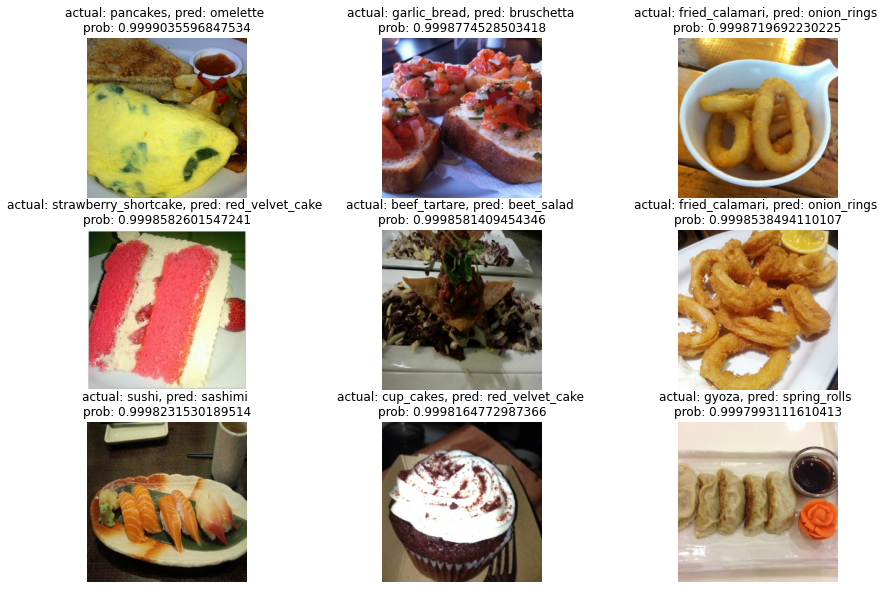

In [ ]:
# Visualizing the wrong predictions:
image_to_view = 9
start_index = 10
plt.figure(figsize = (15,10))
# loop through each row and extract some features and plot them
# eah row in the data frame is a tuple that you can index
for i, row in enumerate(top_100_wrong[start_index : start_index + image_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  # get the image to show
  img = load_and_prep_image(row[1], scale = True)
  _, _, _, _, pred_conf, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_conf}")
  plt.axis(False)


In [ ]:
# run the model on custom images:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2023-01-08 07:12:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  7.56MB/s    in 1.7s    

2023-01-08 07:12:02 (7.56 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
# get the all image paths
image_paths = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]

image_paths

['custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg']

1/1 [==============================] - 0s 46ms/step


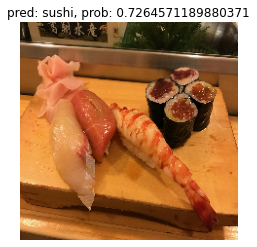

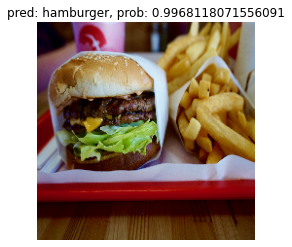

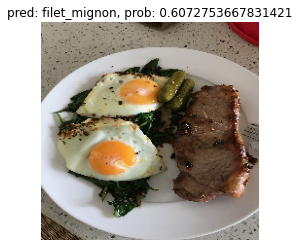

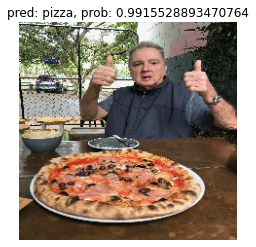

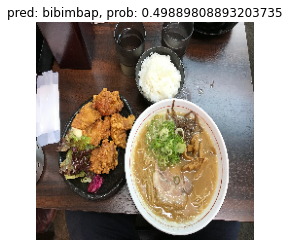

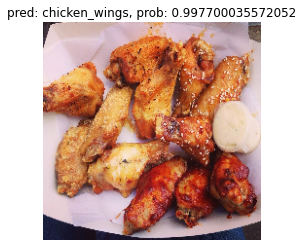

In [ ]:
for img in image_paths:
  img = load_and_prep_image(img, scale = False)
  pred = model.predict(tf.expand_dims(img, axis = 0))
  pred_classname = class_names[pred.argmax()]

  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_classname}, prob: {pred.max()}")
  plt.axis(False)